$$
{\huge \text{Model selection bias: a simple solution}}
$$

$$
{\scriptsize \text{Massimo Pierini, 2025}}
$$

It is well known that model selection procedures invalidate classical inference on the parameters of the selected model (Berk 2010, 2013; Leeb 2005; Pötscher 1991).

Is has been proposed that a simple solution could be to split the data in two parts, using the first to perform the model selection and the second for inference "as usual" (Berk 2010, Rodriguez 2020).

The aim of this notebook is to provide a simple and fully reproducible simulation to verify whether this procedure can avoid the bias.

# INTRODUCTION

In this simple simulation, we'll experimentally verify whether splitting the data can avoid a model selection procedure distorsions over the distribution of the estimators so that the classical inference can be safely applied to the selected model (Berk 2010, Rodriguez 2020).

We'll use a modified version of the "Simulations of Model-Selection", section 4 of "Statistical Inference After Model Selection" (Berk 2010).

# DEFINITION

For this simulation, the full regression model takes the form of

\begin{equation}
y_i = \beta_0 + \beta_w w_i + \beta_x x_i + \beta_z z_i + \varepsilon_i
\end{equation}
where

\begin{equation}
\left\{
\begin{array}{l}
\beta_0 = 3.0
\\
\beta_w = 0.0
\\
\beta_x = 0.50
\\
\beta_z = 0.25
\end{array}
\right.
\end{equation}

and $\varepsilon_i \overset{iid}{\sim} N(0, \sigma_\varepsilon^2)$.

Because the parameter $\beta_w = 0$ in equation $(1)$, many would refer to a submodel that excluded $W$ as
the “correct” model. But equation $(1)$ is also correct as long at $\beta_w = 0$ is
allowed. Therefore, we will use the adjective “preferred” for the model with
$W$ excluded. The full model and the preferred model will generate the same
conditional expectations for the response. The smaller model is preferred
because it is simpler and uses up one less degree of freedom (Berk 2009).

All three predictors are drawn at random from a multivariate normal
distribution with null means.

The
variances and covariances are set as follows: 
$\sigma_\varepsilon^2 = 10.0$, 
$\sigma_w^2 = 5.0$, 
$\sigma_x^2 = 6.0$,
$\sigma_z^2 = 7.0$, 
$\sigma_{w,x} = 4.0$, 
$\sigma_{w,z} = 5.0$, 
and $\sigma_{x,z} = 5.0$,
therefore leading to the following covariance matrix $\Sigma$

\begin{equation}
\Sigma = 
\begin{bmatrix}
5 & 4 & 5
\\
4 & 6 & 5
\\
5 & 5 & 7
\end{bmatrix}
\end{equation}

The sample size will be 400.

10,000 samples will be drawn; the samples will be splitted into selection-inference with a proportion of $0.5$; forward stepwise regression minimizing AIC applied to each selection subset, and sampling distributions will be constructed from the final models selected with the inference subset. In addition to plotting estimated regression coeﬃcients, conventional t-values will be plotted. The usual null hypothesis will be assumed; each regression coeﬃcient has
a population value $0.0$. 

A distribution of t-values is more informative than
a distribution of regression coeﬃcients because it takes the regression coeﬃcients and their standard errors into account (Berk 2009).

# SIMULATIONS

First of all, let's make the needed imports

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

and define the "true" coefficients, variances, covariances, and sample size. We'll set a seed (`random_state`) to ensure reproducibility.

In [2]:
# true model coefficients
beta0 = 3.0
betaw = 0.0
betax = .50
betaz = .25
N = 400
# random errors distribution
epsilon = sps.norm(loc=0, scale=np.sqrt(10.0))
# predictors drawing from a multinormal distribution
X = sps.multivariate_normal(mean=[0, 0, 0], cov=[
    [ 5,  4,  5],
    [ 4,  6,  5],
    [ 5,  5,  7]
]).rvs(N, random_state=42)

Let's now draw a sample of $Y$ using model $(1)$ and take a look at a pairplot of the resulting data.

In [3]:
Y = beta0 + betaw*X[:,0] + betax*X[:,1] + betaz*X[:,2] + epsilon.rvs(N, random_state=1976)

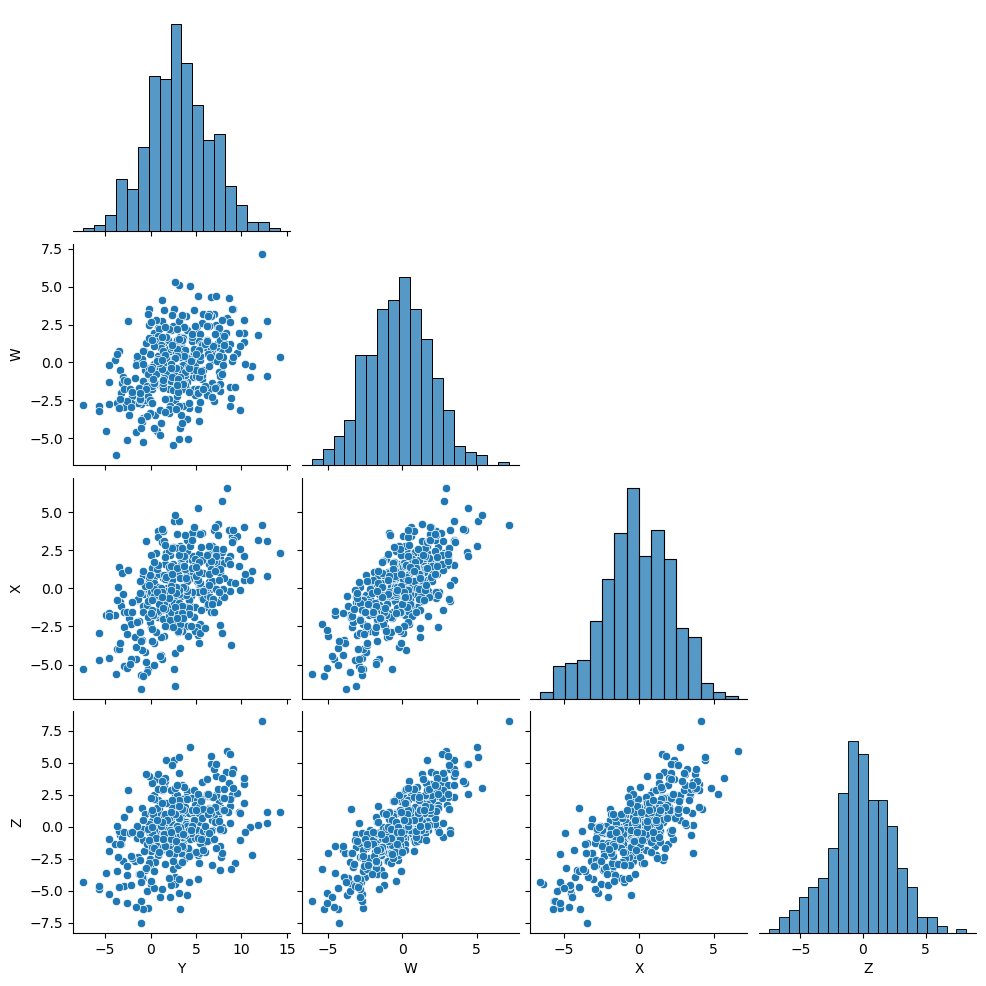

In [4]:
df = pd.DataFrame({
        "Y":Y, "W": X[:,0], "X": X[:,1], "Z": X[:,2]
    })
sns.pairplot(df, corner=True)
plt.show()

In [5]:
sm.OLS.from_formula("Y ~ 1", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 28 Sep 2025   Prob (F-statistic):                nan
Time:                        21:11:54   Log-Likelihood:                -1073.1
No. Observations:                 400   AIC:                             2148.
Df Residuals:                     399   BIC:                             2152.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1048      0.177     17.527      0.000       2.757       3.453
==============================================================================
Omnibus:                        0.773   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.679   Jarque-Bera (JB):                0.683
Skew:                           0.100   Prob(JB):                        0.711
Kurtosis:                       3.026   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's now define the forward stepwise selection procedure (modified from https://ujangriswanto08.medium.com/mastering-stepwise-linear-regression-in-python-from-theory-to-practice-d7293d635240).

In [6]:
def forward_selection(X, y, verbose=False):
    selected_features = []
    remaining_features = list(X.columns)
    model = sm.OLS.from_formula("Y ~ 1", data=pd.DataFrame({"Y": y})).fit() # null model, intercept only
    best_aic = model.aic

    if verbose: print("------------ START -------------")
    while remaining_features:
        if verbose: print(f"Selected features:  {selected_features}")
        if verbose: print(f"Remaining features: {remaining_features}")
        aic_with_candidates = []
        
        for candidate in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[selected_features + [candidate]])).fit()
            if verbose: print(f"  AIC of {candidate}: {model.aic}")
            aic_with_candidates.append((model.aic, candidate))
        
        aic_with_candidates.sort()  # Sort by AIC
        best_new_aic, best_candidate = aic_with_candidates[0]
        if verbose: print(f"    Best: {best_candidate} (AIC: {best_new_aic})")

        if best_new_aic < best_aic:
            if verbose: print("    BEST NEW AIC less than PREVIOUS")
            best_aic = best_new_aic
            selected_features.append(best_candidate)
            remaining_features.remove(best_candidate)
        else:
            if verbose: print("    BEST NEW AIC greater than PREVIOUS")
            break
    if verbose: print(f"SELECTED MODEL: {selected_features}")
    if verbose: print("------------ END -------------")
    return selected_features

Let's now start the simulation, collecting: 

- the parameter estimates for each selected model and for the preferred model
- the t-test statistics for each selected model and for the preferred model
- the $R^2$ coefficient of determination for each selected model and for the preferred model

We'll set a seed for both each drawing and selection-inference split to ensure reproducibility.

Notice we do not (and we do not need nor want to) take other samples of the predictors: the predictors are not random variables, they're fixed and known without errors. $\pmb Y$ is a random variable, because of the identically and independently distributed random errors $\pmb \varepsilon$.

In [7]:
# samples numnber
rep = 10000
# init results
models = {
    "beta_0": [],
    "beta_w": [],
    "beta_x": [],
    "beta_z": [],
    "tval_0": [],
    "tval_W": [],
    "tval_X": [],
    "tval_Z": [],
    "R2": []
}
pref_model = {
    "beta_0": [],
    "beta_w": [],
    "beta_x": [],
    "beta_z": [],
    "tval_0": [],
    "tval_W": [],
    "tval_X": [],
    "tval_Z": [],
    "R2": []
}
# simulation
for i in tqdm(range(rep)):
    # draw a sample of Y given equation (1)
    Y = beta0 + betaw*X[:,0] + betax*X[:,1] + betaz*X[:,2] + epsilon.rvs(N, random_state=i)
    df = pd.DataFrame({
        "Y":Y, "W": X[:,0], "X": X[:,1], "Z": X[:,2]
    })
    x = df.drop('Y', axis=1)  # Features
    y = df['Y']               # Target variable
    # split the data into selection-inference
    X_selection, X_inference, y_selection, y_inference = train_test_split(x, y, test_size=0.5, random_state=i)
    # forward stepwise model selection on the subset
    selected_features = forward_selection(X_selection, y_selection)
    # selected model
    df_inference = X_inference
    df_inference["Y"] = y_inference
    # inference on the other subset
    if len(selected_features):
        mod = sm.OLS.from_formula("Y ~ " + " + ".join(selected_features), data=df_inference).fit()
    else:
        mod = sm.OLS.from_formula("Y ~ 1", data=df_inference).fit()
    # collect estimates, t-test statistics and R-squared
    models["tval_0"].append(mod.tvalues.Intercept)
    models["beta_0"].append(mod.params.Intercept)
    if "W" in selected_features:
        models["tval_W"].append(mod.tvalues.W)
        models["beta_w"].append(mod.params.W)
    else:
        models["tval_W"].append(None)
        models["beta_w"].append(None)
    if "X" in selected_features:
        models["tval_X"].append(mod.tvalues.X)
        models["beta_x"].append(mod.params.X)
    else:
        models["tval_X"].append(None)
        models["beta_x"].append(None)
    if "Z" in selected_features:
        models["tval_Z"].append(mod.tvalues.Z)
        models["beta_z"].append(mod.params.Z)
    else:
        models["tval_Z"].append(None)
        models["beta_z"].append(None)
    models["R2"].append(mod.rsquared)
    # preferred model (on the inference subset)
    mod = sm.OLS.from_formula("Y ~ X + Z", data=df_inference).fit()
    # collect estimates, t-test statistics and R-squared
    pref_model["beta_0"].append(mod.params.Intercept)
    pref_model["beta_w"].append(0)
    pref_model["beta_x"].append(mod.params.X)
    pref_model["beta_z"].append(mod.params.Z)
    pref_model["tval_0"].append(mod.tvalues.Intercept)
    pref_model["tval_W"].append(None)
    pref_model["tval_X"].append(mod.tvalues.X)
    pref_model["tval_Z"].append(mod.tvalues.Z)
    pref_model["R2"].append(mod.rsquared)

  0%|          | 0/10000 [00:00<?, ?it/s]

# RESULTS

Let's define `DataFrame`s of the results.

In [8]:
DF = pd.DataFrame(models)
DF

,beta_0,beta_w,beta_x,beta_z,tval_0,tval_W,tval_X,tval_Z,R2
0,2.897389,0.224683,0.640561,NaN,12.976624,1.590185,5.081611,NaN,0.247859
1,3.217052,NaN,0.558457,0.123503,14.622043,NaN,3.861664,0.934954,0.202137
2,2.970276,NaN,0.809670,NaN,12.232346,NaN,7.701005,NaN,0.230487
3,3.109890,NaN,0.639364,NaN,14.039716,NaN,6.605682,NaN,0.180582
4,3.157325,NaN,0.380259,0.372683,14.004366,NaN,2.601548,2.689605,0.233983
...,...,...,...,...,...,...,...,...,...
9995,3.013597,NaN,0.548878,0.194308,13.393895,NaN,3.815060,1.481599,0.227330
9996,3.273120,NaN,0.831881,NaN,13.434110,NaN,8.169267,NaN,0.252088
9997,2.800464,NaN,0.352622,0.315272,13.197325,NaN,2.475546,2.472437,0.182346
9998,3.299853,-0.140119,0.341798,0.381035,14.114023,-0.716050,2.220950,2.055060,0.139982


In [9]:
PR = pd.DataFrame(pref_model)
PR

,beta_0,beta_w,beta_x,beta_z,tval_0,tval_W,tval_X,tval_Z,R2
0,2.873665,0,0.463308,0.393433,13.157534,None,3.393783,3.125296,0.274191
1,3.217052,0,0.558457,0.123503,14.622043,None,3.861664,0.934954,0.202137
2,2.974998,0,0.683881,0.159917,12.259887,None,4.505850,1.148309,0.235603
3,3.107991,0,0.512888,0.156826,14.042075,None,3.499974,1.148787,0.186035
4,3.157325,0,0.380259,0.372683,14.004366,None,2.601548,2.689605,0.233983
...,...,...,...,...,...,...,...,...,...
9995,3.013597,0,0.548878,0.194308,13.393895,None,3.815060,1.481599,0.227330
9996,3.264733,0,0.733890,0.117917,13.377042,None,4.681032,0.822508,0.254647
9997,2.800464,0,0.352622,0.315272,13.197325,None,2.475546,2.472437,0.182346
9998,3.300201,0,0.317259,0.294901,14.133033,None,2.117214,2.092650,0.137732


Let's plot the distribution (KDE) of $R^2$ for both the selected models and the preferred model.

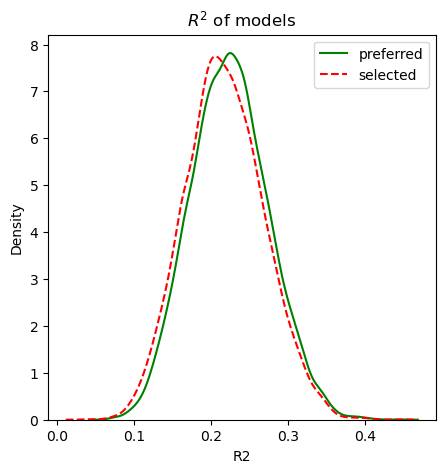

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(PR.R2, label="preferred", color="g")
sns.kdeplot(DF.R2, label="selected", color="r", ls="--")
plt.legend()
plt.title("$R^2$ of models")
plt.show()

Although quite poor, we do not care here for the value itself but for the distribution.

We can see that the coefficient of determinations distributions seem slightly different. We could also perform a two-samples Kolmogorov-Smirnov test to test the null hypothesis that the two samples have been drawn from the same distribution.

To perform the KS test, we'll first calculate the optimal sample size for a significance level of $5\%$ and a desired power of $80\%$. Then, since the KS test is too "strict", we'll define that two samples are not "too different" if their KS test statistic is not greater than $5\%$.

In [11]:
def optimal_ks_size(df1, df2, col):
    KS = sps.ks_2samp(df1[col].dropna(), df2[col].dropna(), nan_policy="raise", alternative="two-sided")
    x_str = KS.statistic_location
    p = df1[df1[col]<=x_str].index.size/df1.index.size
    q = df2[df2[col]<=x_str].index.size/df2.index.size
    S = p*(1-p) + q*(1-q)
    delta = KS.statistic
    c = 1.358 # for alpha=.05
    z = .8416 # for gamma=.80
    n_opt = int(np.round(((z*np.sqrt(S) + c*np.sqrt(2))/delta)**2))
    return n_opt

In [12]:
n_R2 = optimal_ks_size(DF, PR, "R2")
n_R2

1557

In [13]:
sps.ks_2samp(DF.R2.dropna(), PR.R2.dropna(), nan_policy="raise", alternative="two-sided")

KstestResult(statistic=0.0637, pvalue=4.65213246363271e-18, statistic_location=0.21589133808148764, statistic_sign=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

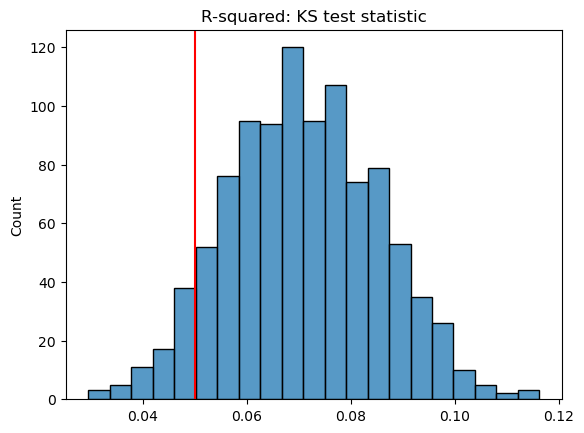

In [14]:
KSs = []
subsize = n_R2
for i in tqdm(range(1000)):
    _df = DF[DF.index.isin(np.random.choice(DF.index, size=subsize, replace=False))]
    _pr = PR[PR.index.isin(np.random.choice(PR.index, size=subsize, replace=False))]
    ks = sps.ks_2samp(_df.R2.dropna(), _pr.R2.dropna(), nan_policy="raise", alternative="two-sided")
    KSs.append(ks.statistic)
KSs = np.array(KSs)
sns.histplot(KSs)
plt.axvline(.05, color="r")
plt.title("R-squared: KS test statistic")
plt.show()

The KS test statistic if often greater than $.05$. We must conclude that we have to reject the hypothesis that the $R^2$ samples have been drawn from the same distribution.

Let's now compute the absolute and relative frequencies of the 8 possible models, selected by the forward stepwise procedure.

In [15]:
perc_selection = pd.DataFrame({
    "null": [DF[(DF.tval_W.isna())&(DF.tval_X.isna())&(DF.tval_Z.isna())].index.size],
    "W": [DF[(~DF.tval_W.isna())&(DF.tval_X.isna())&(DF.tval_Z.isna())].index.size],
    "X": [DF[(DF.tval_W.isna())&(~DF.tval_X.isna())&(DF.tval_Z.isna())].index.size],
    "Z": [DF[(DF.tval_W.isna())&(DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size],
    "WX": [DF[(~DF.tval_W.isna())&(~DF.tval_X.isna())&(DF.tval_Z.isna())].index.size],
    "WZ": [DF[(~DF.tval_W.isna())&(DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size],
    "XZ": [DF[(DF.tval_W.isna())&(~DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size],
    "WXZ": [DF[(~DF.tval_W.isna())&(~DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size]
})
perc_selection.style.hide(axis="index").set_caption("SELECTED MODELS ABSOLUTE FREQUENCIES")

null,W,X,Z,WX,WZ,XZ,WXZ
0,5,2721,195,1287,58,5113,621


In [16]:
perc_selection = pd.DataFrame({
    "null": [DF[(DF.tval_W.isna())&(DF.tval_X.isna())&(DF.tval_Z.isna())].index.size/rep],
    "W": [DF[(~DF.tval_W.isna())&(DF.tval_X.isna())&(DF.tval_Z.isna())].index.size/rep],
    "X": [DF[(DF.tval_W.isna())&(~DF.tval_X.isna())&(DF.tval_Z.isna())].index.size/rep],
    "Z": [DF[(DF.tval_W.isna())&(DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size/rep],
    "WX": [DF[(~DF.tval_W.isna())&(~DF.tval_X.isna())&(DF.tval_Z.isna())].index.size/rep],
    "WZ": [DF[(~DF.tval_W.isna())&(DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size/rep],
    "XZ": [DF[(DF.tval_W.isna())&(~DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size/rep],
    "WXZ": [DF[(~DF.tval_W.isna())&(~DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size/rep]
})
perc_selection.style.hide(axis="index").format('{:.2%}').set_caption("SELECTED MODELS RELATIVE FREQUENCIES")

null,W,X,Z,WX,WZ,XZ,WXZ
0.00%,0.05%,27.21%,1.95%,12.87%,0.58%,51.13%,6.21%


We see that

- the preferred model has been selected approx. $51\%$ of the times

- the null model has never been selected

- the full model has been selected approx. $6\%$ of the times

- respectively, approx. $27\%$ and $13\%$ of the times, models with $X$ and with both $X$ and $W$ have been selected

- other models (with $W$, with $Z$, and with $WZ$) have been selected less than $2\%$ of times

Let's take a look at the relative frequencies of each predictor having been included in the selected model.

In [17]:
perc_predictor = pd.DataFrame({
    "W": [DF[(~DF.tval_W.isna())].index.size/rep],
    "X": [DF[(~DF.tval_X.isna())].index.size/rep],
    "Z": [DF[(~DF.tval_Z.isna())].index.size/rep]
})
perc_predictor.style.hide(axis="index").format('{:.2%}').set_caption("INCLUDED PREDICTORS RELATIVE FREQUENCIES")

W,X,Z
19.71%,97.42%,59.87%


Notice that the predictor $W$ has been included a non-zero percentage of the times (approx. $19\%$...!), even if we know that the "true" value of $\beta_w$ is null.

Let's now plot the distributions (KDE) of the parameters' estimates for both the preferred and the selected models.

For the selected models, the distributions for each predictor's parameter are conditional on the predictor having been included in the selected model.

/var/folders/b5/91v33kb942vd3xw6d7cgsgbm0000gn/T/ipykernel_39805/1673371828.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(PR.beta_w, label="preferred", color="g", ax=ax[1,0])


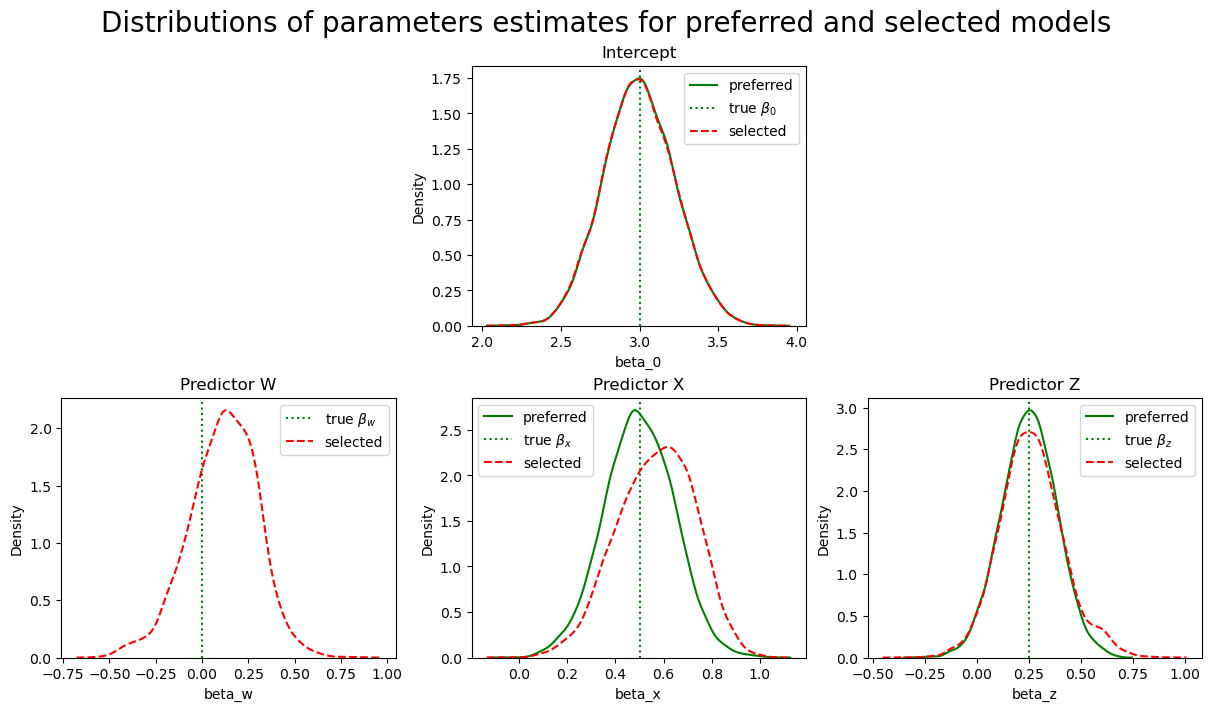

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7), layout="constrained")

ax[0,0].axis(False)
ax[0,2].axis(False)

sns.kdeplot(PR.beta_0, label="preferred", color="g", ax=ax[0,1])
ax[0,1].axvline(beta0, color="g", ls=":", label=r"true $\beta_0$")
sns.kdeplot(DF.beta_0, label="selected", color="r", ls="--", ax=ax[0,1])
ax[0,1].legend()
ax[0,1].set_title("Intercept")

sns.kdeplot(PR.beta_w, label="preferred", color="g", ax=ax[1,0])
ax[1,0].axvline(betaw, color="g", ls=":", label=r"true $\beta_w$")
sns.kdeplot(DF.beta_w, label="selected", color="r", ls="--", ax=ax[1,0])
ax[1,0].legend()
ax[1,0].set_title("Predictor W")

sns.kdeplot(PR.beta_x, label="preferred", color="g", ax=ax[1,1])
ax[1,1].axvline(betax, color="g", ls=":", label=r"true $\beta_x$")
sns.kdeplot(DF.beta_x, label="selected", color="r", ls="--", ax=ax[1,1])
ax[1,1].legend()
ax[1,1].set_title("Predictor X")

sns.kdeplot(PR.beta_z, label="preferred", color="g", ax=ax[1,2])
ax[1,2].axvline(betaz, color="g", ls=":", label=r"true $\beta_z$")
sns.kdeplot(DF.beta_z, label="selected", color="r", ls="--", ax=ax[1,2])
ax[1,2].legend()
ax[1,2].set_title("Predictor Z")

fig.suptitle("Distributions of parameters estimates for preferred and selected models", fontsize=20)

plt.show()

We notice that

- we do not have any distribution for predictor $W$ in the preferred model, since it wasn't included, but we have an unimodal distribution for $W$ in the selected models since it has been selected approx. $20\%$ of times, and it doesn't seem normal

- the distribution for $X$ seems 'enough' normal for the preferred model, but it doesn't seem normal for the selected models

- the distribution for $Z$ seems 'enough' normal for the preferred model, but it looks less normally distributed for the selected models

We could also perform Anderson-Darling tests to test the null hypothesis that the observed parameters' estimates have been drawn from a normal distribution.

In [19]:
sps.anderson(PR.beta_x), sps.anderson(PR.beta_z)

(AndersonResult(statistic=0.3683900106279907, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.4985519210286295, scale=0.1454167362120283)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'),
 AndersonResult(statistic=0.43813950068943086, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.25072084297352504, scale=0.1336427551611639)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'))

In [20]:
sps.anderson(DF.beta_w.dropna()), sps.anderson(DF.beta_x.dropna()), sps.anderson(DF.beta_z.dropna())

(AndersonResult(statistic=3.4344302089598386, critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.11367590349833284, scale=0.18462705802079424)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'),
 AndersonResult(statistic=12.178434254430613, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.568032774255016, scale=0.16019462757798925)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'),
 AndersonResult(statistic=8.53317747906658, critical_values=array([0.576, 0.656, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.26418256684575137, scale=0.1528937968727171)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'

We see that we reject the null hypothesis for all parameters' estimates of the selected models, and we fail to reject the null hypothesis for all parameters' estimates of the preferred model. This confirms what we visually suspected.

Let's now plot the distributions (KDE) of t-test statistics of each predictor for both the selected and the preferred model.

For the selected models, the distributions of the t-test statistics for each predictor's parameter are conditional on the predictor having been included in the selected model.

/var/folders/b5/91v33kb942vd3xw6d7cgsgbm0000gn/T/ipykernel_39805/2880685200.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(PR.tval_W, label="preferred", color="g", ax=ax[1,0])


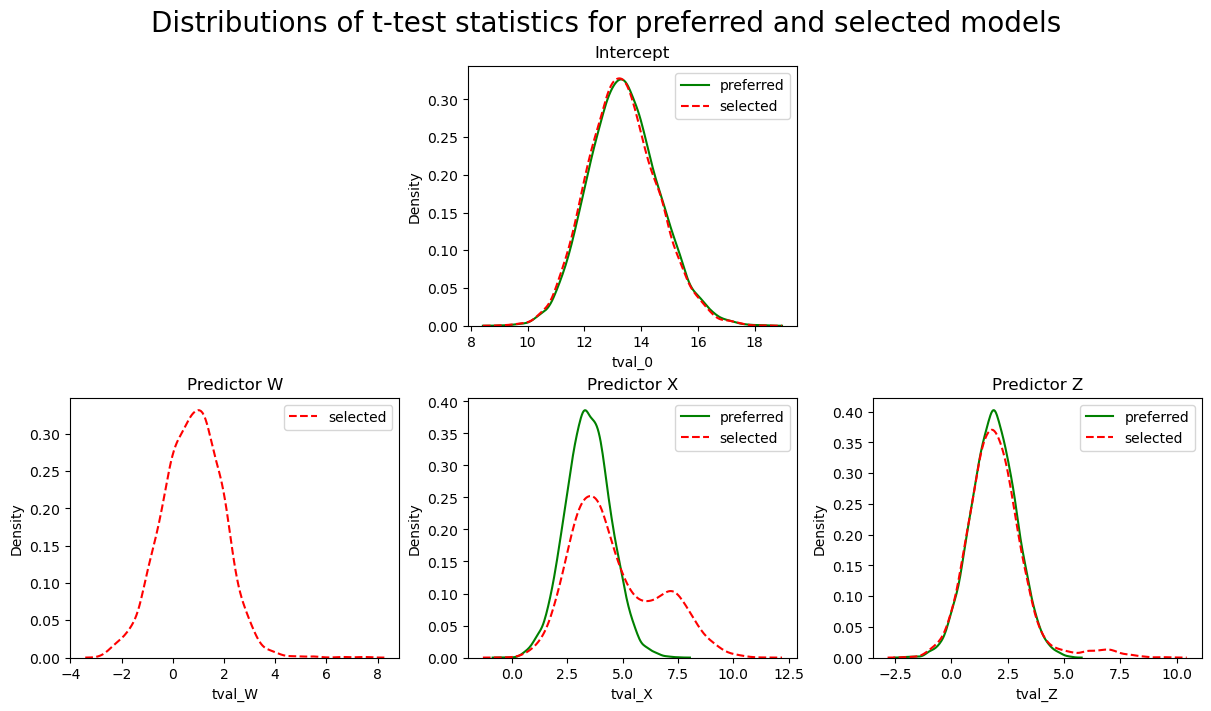

In [21]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7), layout="constrained")

ax[0,0].axis(False)
ax[0,2].axis(False)

sns.kdeplot(PR.tval_0, label="preferred", color="g", ax=ax[0,1])
sns.kdeplot(DF.tval_0, label="selected", color="r", ls="--", ax=ax[0,1])
ax[0,1].legend()
ax[0,1].set_title("Intercept")

sns.kdeplot(PR.tval_W, label="preferred", color="g", ax=ax[1,0])
sns.kdeplot(DF.tval_W, label="selected", color="r", ls="--", ax=ax[1,0])
ax[1,0].legend()
ax[1,0].set_title("Predictor W")

sns.kdeplot(PR.tval_X, label="preferred", color="g", ax=ax[1,1])
sns.kdeplot(DF.tval_X, label="selected", color="r", ls="--", ax=ax[1,1])
ax[1,1].legend()
ax[1,1].set_title("Predictor X")

sns.kdeplot(PR.tval_Z, label="preferred", color="g", ax=ax[1,2])
sns.kdeplot(DF.tval_Z, label="selected", color="r", ls="--", ax=ax[1,2])
ax[1,2].legend()
ax[1,2].set_title("Predictor Z")

fig.suptitle("Distributions of t-test statistics for preferred and selected models", fontsize=20)

plt.show()

We can notice that

- we do not have any distribution for predictor $W$ in the preferred model, since it wasn't included, but we have an unimodal distribution for $W$ in the selected models since it has been included approx. $20\%$ of the times

- the distribution for $X$ for the selected models is definitely different from the preferred model, and clearly bimodal

- the distribution for $Z$ for the selected models is somehow similar to the preferred model, but it looks bimodal

We could also perform a two-samples Kolmogorov-Smirnov test to test the null hypothesis that the samples (for $X$ and $Z$) have been drawn from the same distribution.

In [22]:
n_tvalX = optimal_ks_size(DF, PR, "tval_X")
n_tvalX

69

  0%|          | 0/1000 [00:00<?, ?it/s]

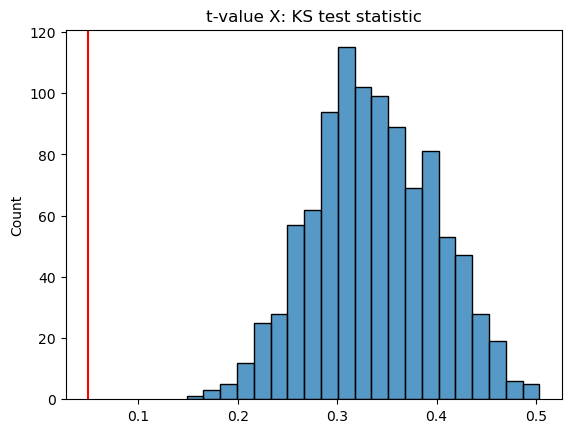

In [23]:
KSs = []
subsize = n_tvalX
for i in tqdm(range(1000)):
    _df = DF[DF.index.isin(np.random.choice(DF.index, size=subsize, replace=False))]
    _pr = PR[PR.index.isin(np.random.choice(PR.index, size=subsize, replace=False))]
    ks = sps.ks_2samp(_df.tval_X.dropna(), _pr.tval_X.dropna(), nan_policy="raise", alternative="two-sided")
    KSs.append(ks.statistic)
KSs = np.array(KSs)
sns.histplot(KSs)
plt.axvline(.05, color="r")
plt.title("t-value X: KS test statistic")
plt.show()

In [24]:
n_tvalZ = optimal_ks_size(DF, PR, "tval_Z")
n_tvalZ

4765

  0%|          | 0/1000 [00:00<?, ?it/s]

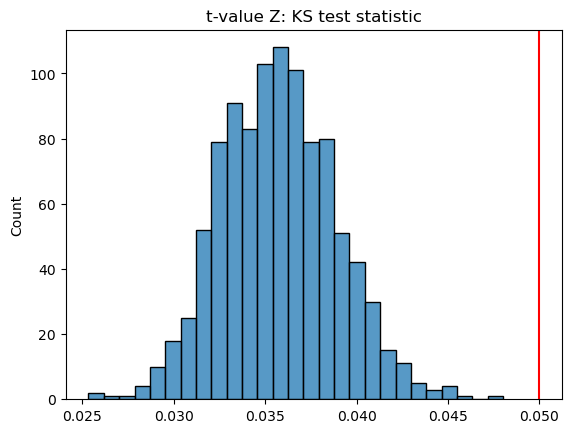

In [25]:
KSs = []
subsize = n_tvalZ
for i in tqdm(range(1000)):
    _df = DF[DF.index.isin(np.random.choice(DF.index, size=subsize, replace=False))]
    _pr = PR[PR.index.isin(np.random.choice(PR.index, size=subsize, replace=False))]
    ks = sps.ks_2samp(_df.tval_Z.dropna(), _pr.tval_Z.dropna(), nan_policy="raise", alternative="two-sided")
    KSs.append(ks.statistic)
KSs = np.array(KSs)
sns.histplot(KSs)
plt.axvline(.05, color="r")
plt.title("t-value Z: KS test statistic")
plt.show()

So, we can conclude that for $Z$ the two samples are "enough similar", but they're quite different for $X$.

# CONCLUSIONS

As pointed out by Berk (2010) and many other Authors who have deeply studied the model selection bias, we have experimentally verified that the model selection procedure distorts the estimators' distributions, invalidating the classical inference on the selected model.

This happens because, as a result of the model selection procedure, the model itself is not "fixed" anymore but becomes a random variable itself (Berk 2013), potentially having dramatic effects on the estimators' distributions, as in the simulation we performed.

This simple experiment fails to verify that the proposed solution of splitting the data into two parts (using the first to select the model and the second for usual inference) can solve the model selection bias (Berk 2010, Rodriguez 2020): both the parameters estimates and the t-test statistics in the selected models are distorted and differently distributed with respect to the preferred model.

# ESSENTIAL BIBLIOGRAPHY

Berk, R., Brown, L., & Zhao, L. (2010). Statistical inference after model selection. _Journal of Quantitative Criminology, 26(2)_, 217-236.

Berk, R., Brown, L., Buja, A., Zhang, K., & Zhao, L. (2013). Valid post-selection inference. _The Annals of Statistics_, 802-837.

Leeb, H., & Pötscher, B. M. (2005). Model selection and inference: Facts and fiction. _Econometric Theory, 21(1)_, 21-59.

Pötscher, B. M. (1991). Effects of model selection on inference. _Econometric Theory, 7(2)_, 163-185.

Rodriguez, J. (2020). Model Selection Bias. https://josue.rbind.io/post/model-selection-bias/ (Accessed 2025-09-27).

Many other papers, even more recent, can be found in the literature. 